In [1]:
import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath

from datetime import datetime, timedelta

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

import os
import sys

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import gsw
import pyresample
from xgcm import Grid
import xesmf as xe

In [2]:
    %%time
    
    # load waom4 3D temp field to plot some maps
    path_ECCO2_4km = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_00*.nc'
    
    # ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
    ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag_daily//ocean_avg_00*.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
    # temp3d_4km= ds.temp
    zeta_4km= ds.zeta
    # melt_4km= ds.m
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    # calc dz:
    hwater = ds.h -abs(ds.zice) # replace ds.h for hwater below
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    z_rho3d_4km = ds.zeta + (ds.zeta + hwater) * Zo_rho -abs(ds.zice)
    del Zo_rho
    ds.close()
    
    # ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-10yr_notides/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
    ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_notides_diag_daily//ocean_avg_00*.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
    # temp3d_4kmNT= ds.temp
    zeta_4kmNT= ds.zeta
    # melt_4kmNT= ds.m
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    # calc dz:
    hwater = ds.h -abs(ds.zice) # replace ds.h for hwater below
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    z_rho3d_4kmNT = ds.zeta + (ds.zeta + hwater) * Zo_rho -abs(ds.zice)
    del Zo_rho
    ds.close()
    
    # ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
    ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
    # temp3d_10km= ds.temp
    zeta_10km= ds.zeta
    # melt_10km= ds.m
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    # calc dz:
    hwater = ds.h -abs(ds.zice) # replace ds.h for hwater below
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    z_rho3d_10km = ds.zeta + (ds.zeta + hwater) * Zo_rho -abs(ds.zice)
    del Zo_rho
    ds.close()
    
    # read grid file for lon/lat coordinates
    dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")
    lat_rho_4km= dg.lat_rho
    lon_rho_4km = dg.lon_rho
    lat_u_4km= dg.variables["lat_u"]
    lon_u_4km = dg.variables["lon_u"]
    lat_v_4m= dg.variables["lat_v"]
    lon_v_4km = dg.variables["lon_v"]
    pm_4km = dg.pm
    pn_4km = dg.pn
    zice_4km = dg.variables["zice"]
    h_4km = dg.variables["h"]
    cor_4km = dg.variables["f"]
    dg.close()
    print('Print lon/lat_rho shapes',lon_rho_4km.shape, lat_rho_4km.shape)
    print('Print lon/lat_rho shapes',lon_rho_4km[0:-1,0:-1].shape, lat_rho_4km[0:-1,0:-1].shape)
    
    dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
    lat_rho_10km= dg.lat_rho
    lon_rho_10km = dg.lon_rho
    lat_u_10km= dg.variables["lat_u"]
    lon_u_10km = dg.variables["lon_u"]
    lat_v_10km= dg.variables["lat_v"]
    lon_v_10km = dg.variables["lon_v"]
    pm_10km = dg.pm
    pn_10km = dg.pn
    zice_10km = dg.variables["zice"]
    h_10km = dg.variables["h"]
    cor_10km = dg.variables["f"]
    dg.close()
    
    # temp3d_4km.load()
    zeta_4km.load()
    
    # temp3d_4kmNT.load()
    zeta_4kmNT.load()
    
    # temp3d_10km.load()
    zeta_10km.load()

Print lon/lat_rho shapes (1400, 1575) (1400, 1575)
Print lon/lat_rho shapes (1399, 1574) (1399, 1574)
CPU times: user 1min 3s, sys: 37.6 s, total: 1min 41s
Wall time: 3min 17s


<xarray.DataArray 'zeta' (ocean_time: 365, eta_rho: 560, xi_rho: 630)>
array([[[-0.15913777, -0.15913777, -0.16864905, ..., -0.50215876,
         -0.49773026, -0.49773026],
        [-0.15913777, -0.1591116 , -0.1686226 , ..., -0.5021617 ,
         -0.49773246, -0.49773026],
        [-0.16545093, -0.16542557, -0.17442398, ..., -0.50651073,
         -0.50162905, -0.5016265 ],
        ...,
        [-0.86557746, -0.86554515, -0.8780708 , ..., -1.1493288 ,
         -1.1407232 , -1.1406646 ],
        [-0.85909635, -0.85906446, -0.8723606 , ..., -1.1450036 ,
         -1.1353831 , -1.1353254 ],
        [-0.85909635, -0.85909635, -0.87239337, ..., -1.1449445 ,
         -1.1353254 , -1.1353254 ]],

       [[-0.1545907 , -0.1545907 , -0.16327289, ..., -0.49542412,
         -0.49226448, -0.49226448],
        [-0.1545907 , -0.15459438, -0.16327748, ..., -0.49543712,
         -0.4922779 , -0.49226448],
        [-0.16069308, -0.16069707, -0.16881242, ..., -0.49833587,
         -0.49526206, -0.49524876],
...
        [-0.86926574, -0.86927366, -0.8825995 , ..., -1.1596898 ,
         -1.1525376 , -1.1525395 ],
        [-0.8637957 , -0.8638045 , -0.87794024, ..., -1.1555967 ,
         -1.1474406 , -1.1474425 ],
        [-0.8637957 , -0.8637957 , -0.87793237, ..., -1.1555988 ,
         -1.1474425 , -1.1474425 ]],

       [[-0.1474838 , -0.1474838 , -0.15776688, ..., -0.4972354 ,
         -0.4933652 , -0.4933652 ],
        [-0.1474838 , -0.14748424, -0.15776828, ..., -0.49724132,
         -0.4933715 , -0.4933652 ],
        [-0.15408804, -0.154089  , -0.16456145, ..., -0.5014704 ,
         -0.49686918, -0.49686292],
        ...,
        [-0.8687304 , -0.8687355 , -0.8812899 , ..., -1.1615257 ,
         -1.1519557 , -1.1519593 ],
        [-0.86284083, -0.86284685, -0.8761205 , ..., -1.1552182 ,
         -1.1450275 , -1.1450312 ],
        [-0.86284083, -0.86284083, -0.87611544, ..., -1.1552219 ,
         -1.1450312 , -1.1450312 ]]], dtype=float32)
Coordinates:
    x_rho       (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    y_rho       (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * ocean_time  (ocean_time) datetime64[ns] 2025-12-27T12:00:00 ... 2026-12-2...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged free-surface
    units:      meter
    time:       ocean_time
    field:      free-surface, scalar, series

In [3]:
# # calculate geostrophic velocities from ssh:
#         g = 9.81
#         dzetady = np.diff(zeta_tmp, axis=1)
#         dzetadx = np.diff(zeta_tmp, axis=2)
#         mmax = 12
#         dzeta_dy = np.empty((dzetady[:,:,0:-1].shape))
#         dzeta_dx = np.empty((dzetadx[:,0:-1,:].shape))
#         for mm in np.arange(0,mmax,1):
#             dzeta_dy[mm,:,:] = dzetady[mm,:,0:-1]*pn_10km[0:-1,0:-1]
#             dzeta_dx[mm,:,:]= dzetadx[mm,0:-1,:]*pm_10km[0:-1,0:-1]

#         ugeo = np.empty((dzeta_dy.shape))
#         vgeo = np.empty((dzeta_dx.shape))
#         for mm in np.arange(0,mmax,1):
#             ugeo[mm,:,:] = -(g/cor_10km[0:-1,0:-1])*dzeta_dy[mm,:,:]
#             vgeo[mm,:,:] = (g/cor_10km[0:-1,0:-1])*dzeta_dx[mm,:,:]
#         ugeo_ann_tmp = np.nanmean(ugeo, axis=0)
#         vgeo_ann_tmp = np.nanmean(vgeo, axis=0)
#         V_ann_tmp = np.sqrt(ugeo_ann_tmp*ugeo_ann_tmp + vgeo_ann_tmp*vgeo_ann_tmp)
#         MKE_tmp = np.divide(V_ann_tmp*V_ann_tmp,2)
#         print("Size MKE_tmp", MKE_tmp.shape)
        
#         ugeo_anom_tmp = ugeo - ugeo_ann_tmp
#         vgeo_anom_tmp = vgeo - vgeo_ann_tmp
#         V_anom_tmp = np.sqrt(ugeo_anom_tmp*ugeo_anom_tmp + vgeo_anom_tmp*vgeo_anom_tmp)
#         V_anom_ann = np.nanmean(V_anom_tmp, axis=0)
#         EKE_tmp = np.divide(V_anom_ann*V_anom_ann,2)
#         print("Size EKE_tmp", EKE_tmp.shape)

In [4]:
print(cor_10km.shape, pm_10km.shape, pn_10km.shape, zeta_10km.diff('eta_rho').shape)


(560, 630) (560, 630) (560, 630) (365, 559, 630)


In [5]:
g=9.81 # gravity

pm_u_10km = pm_10km.rolling({'xi_rho': 2}).mean() # first column is nan (so actual dimension is 629x560
pn_v_10km = pn_10km.rolling({'eta_rho': 2}).mean() # first row is nan (so actual dimension is 630x559


dzetady_10km = zeta_10km.diff('eta_rho')*pn_v_10km.isel(eta_rho=slice(0,-1))
dzetadx_10km = zeta_10km.diff('xi_rho')*pm_u_10km.isel(xi_rho=slice(0,-1))

ugeo_10km = -g*dzetady_10km/cor_10km.isel(eta_rho=slice(0,-1))
vgeo_10km = g*dzetadx_10km/cor_10km.isel(xi_rho=slice(0,-1))

ugeo_mean_10km = ugeo_10km.mean('ocean_time')
vgeo_mean_10km = vgeo_10km.mean('ocean_time')
ugeo_eddy_10km = ugeo_10km - ugeo_mean_10km
vgeo_eddy_10km = vgeo_10km - vgeo_mean_10km

V_eddy_10km = np.sqrt((ugeo_eddy_10km.isel(xi_rho=slice(0,-1))*ugeo_eddy_10km.isel(xi_rho=slice(0,-1)))
                 +(vgeo_eddy_10km.isel(eta_rho=slice(0,-1))*vgeo_eddy_10km.isel(eta_rho=slice(0,-1))))
V_mean_10km = np.sqrt((ugeo_mean_10km.isel(xi_rho=slice(0,-1))*ugeo_mean_10km.isel(xi_rho=slice(0,-1)))
                 +(vgeo_mean_10km.isel(eta_rho=slice(0,-1))*vgeo_mean_10km.isel(eta_rho=slice(0,-1))))

MKE_10km = np.divide(V_mean_10km*V_mean_10km,2)
EKE_10km = np.divide(V_eddy_10km*V_eddy_10km,2)

print(MKE_10km.shape, EKE_10km.shape)


(559, 629) (365, 559, 629)


In [6]:

pm_u_4km = pm_4km.rolling({'xi_rho': 2}).mean() # first column is nan (so actual dimension is 629x560
pn_v_4km = pn_4km.rolling({'eta_rho': 2}).mean() # first row is nan (so actual dimension is 630x559


dzetady_4km = zeta_4km.diff('eta_rho')*pn_v_4km.isel(eta_rho=slice(0,-1))
dzetadx_4km = zeta_4km.diff('xi_rho')*pm_u_4km.isel(xi_rho=slice(0,-1))

ugeo_4km = -g*dzetady_4km/cor_4km.isel(eta_rho=slice(0,-1))
vgeo_4km = g*dzetadx_4km/cor_4km.isel(xi_rho=slice(0,-1))

ugeo_mean_4km = ugeo_4km.mean('ocean_time')
vgeo_mean_4km = vgeo_4km.mean('ocean_time')
ugeo_eddy_4km = ugeo_4km - ugeo_mean_4km
vgeo_eddy_4km = vgeo_4km - vgeo_mean_4km

V_eddy_4km = np.sqrt((ugeo_eddy_4km.isel(xi_rho=slice(0,-1))*ugeo_eddy_4km.isel(xi_rho=slice(0,-1)))
                 +(vgeo_eddy_4km.isel(eta_rho=slice(0,-1))*vgeo_eddy_4km.isel(eta_rho=slice(0,-1))))
V_mean_4km = np.sqrt((ugeo_mean_4km.isel(xi_rho=slice(0,-1))*ugeo_mean_4km.isel(xi_rho=slice(0,-1)))
                 +(vgeo_mean_4km.isel(eta_rho=slice(0,-1))*vgeo_mean_4km.isel(eta_rho=slice(0,-1))))

MKE_4km = np.divide(V_mean_4km*V_mean_4km,2)
EKE_4km = np.divide(V_eddy_4km*V_eddy_4km,2)

print(MKE_4km.shape, EKE_4km.shape)


(1399, 1574) (365, 1399, 1574)


In [7]:


dzetady_4kmNT = zeta_4kmNT.diff('eta_rho')*pn_v_4km.isel(eta_rho=slice(0,-1))
dzetadx_4kmNT = zeta_4kmNT.diff('xi_rho')*pm_u_4km.isel(xi_rho=slice(0,-1))

ugeo_4kmNT = -g*dzetady_4kmNT/cor_4km.isel(eta_rho=slice(0,-1))
vgeo_4kmNT = g*dzetadx_4kmNT/cor_4km.isel(xi_rho=slice(0,-1))

ugeo_mean_4kmNT = ugeo_4kmNT.mean('ocean_time')
vgeo_mean_4kmNT = vgeo_4kmNT.mean('ocean_time')
ugeo_eddy_4kmNT = ugeo_4kmNT - ugeo_mean_4kmNT
vgeo_eddy_4kmNT = vgeo_4kmNT - vgeo_mean_4kmNT

V_eddy_4kmNT = np.sqrt((ugeo_eddy_4kmNT.isel(xi_rho=slice(0,-1))*ugeo_eddy_4kmNT.isel(xi_rho=slice(0,-1)))
                 +(vgeo_eddy_4kmNT.isel(eta_rho=slice(0,-1))*vgeo_eddy_4kmNT.isel(eta_rho=slice(0,-1))))
V_mean_4kmNT = np.sqrt((ugeo_mean_4kmNT.isel(xi_rho=slice(0,-1))*ugeo_mean_4kmNT.isel(xi_rho=slice(0,-1)))
                 +(vgeo_mean_4kmNT.isel(eta_rho=slice(0,-1))*vgeo_mean_4kmNT.isel(eta_rho=slice(0,-1))))

MKE_4kmNT = np.divide(V_mean_4kmNT*V_mean_4kmNT,2)
EKE_4kmNT = np.divide(V_eddy_4kmNT*V_eddy_4kmNT,2)

print(MKE_4kmNT.shape, EKE_4kmNT.shape)


(1399, 1574) (365, 1399, 1574)


In [8]:
%%time
MKE_10km.load()
EKE_10km.load()
MKE_4km.load()
EKE_4km.load()
MKE_4kmNT.load()
EKE_4kmNT.load()

CPU times: user 296 µs, sys: 859 µs, total: 1.15 ms
Wall time: 1.43 ms


<xarray.DataArray (ocean_time: 365, eta_rho: 1399, xi_rho: 1574)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 2.78912171e-03, 1.23080679e-03, ...,
         7.45169391e-04, 3.62900795e-04, 1.60570856e-04],
        [           nan, 2.09285381e-03, 1.06661015e-03, ...,
         1.41202515e-03, 6.15154089e-04, 3.49058990e-04],
        ...,
        [           nan, 1.56763739e-03, 1.52136354e-03, ...,
         4.31084426e-03, 1.00317150e-02, 1.77165717e-03],
        [           nan, 2.41259654e-03, 2.33717525e-03, ...,
         6.41976572e-03, 1.16645403e-02, 2.41241154e-03],
        [           nan, 7.69799258e-04, 8.30494559e-04, ...,
         6.22069246e-04, 3.99056478e-03, 2.69650889e-10]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 1.77803807e-03, 5.93640703e-04, ...,
         2.03492660e-04, 8.64808916e-05, 4.92344256e-05],
        [           nan, 8.55091191e-04, 4.57422142e-04, ...,
         6.68944902e-04, 2.84740971e-04, 2.68309057e-04],
...
        [           nan, 1.26824583e-03, 1.26445221e-03, ...,
         8.88513548e-04, 2.73356876e-03, 5.58661285e-04],
        [           nan, 1.49114390e-03, 1.69702013e-03, ...,
         1.47496473e-03, 2.54859674e-03, 8.58296209e-04],
        [           nan, 7.22935985e-04, 9.59647593e-04, ...,
         3.30364294e-04, 9.09302682e-04, 1.19571502e-10]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 3.77479811e-03, 1.92776925e-03, ...,
         1.65295596e-03, 3.68986545e-04, 1.59648004e-04],
        [           nan, 3.35390430e-03, 1.60281635e-03, ...,
         2.52712321e-03, 8.35826711e-04, 3.71462357e-04],
        ...,
        [           nan, 1.35704125e-03, 1.08905994e-03, ...,
         1.58649798e-03, 5.05145400e-03, 8.97160366e-04],
        [           nan, 1.96170147e-03, 2.02135844e-03, ...,
         3.31428987e-03, 6.37994699e-03, 1.73557764e-03],
        [           nan, 6.81191487e-04, 9.27548616e-04, ...,
         7.82179761e-04, 2.79747419e-03, 1.86881697e-10]]])
Coordinates:
    x_rho       (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    y_rho       (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * ocean_time  (ocean_time) datetime64[ns] 2015-12-30T12:00:00 ... 2016-12-2...
Dimensions without coordinates: eta_rho, xi_rho

In [9]:
print(MKE_10km.shape, EKE_10km.shape,
    MKE_4km.shape, EKE_4km.shape,
     lon_u_10km.shape, lat_u_10km.shape,
     lon_u_4km.shape, lat_u_4km.shape)


(559, 629) (365, 559, 629) (1399, 1574) (365, 1399, 1574) (560, 629) (560, 629) (1400, 1574) (1400, 1574)


In [16]:
lon_u_4km[0:-1,:].shape

(1399, 1574)

In [20]:
%%time
# interpolate 4km to 10km for plotting differences:

 # re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_u_10km[0:-1,:],lats=lat_u_10km[0:-1,:])
w4_def = pyresample.geometry.SwathDefinition(lons=lon_u_4km[0:-1,:],lats=lat_u_4km[0:-1,:])

wf = lambda r: 1/r

MKE_4km_i = pyresample.kd_tree.resample_custom(w4_def,MKE_4km.values,w10_def,\
                                         radius_of_influence=30000,neighbours=1,weight_funcs=wf)
EKE_4km_i = pyresample.kd_tree.resample_custom(w4_def,EKE_4km.mean('ocean_time').values,w10_def,\
                                         radius_of_influence=30000,neighbours=1,weight_funcs=wf)
MKE_4kmNT_i = pyresample.kd_tree.resample_custom(w4_def,MKE_4kmNT.values,w10_def,\
                                         radius_of_influence=30000,neighbours=1,weight_funcs=wf)
EKE_4kmNT_i = pyresample.kd_tree.resample_custom(w4_def,EKE_4kmNT.mean('ocean_time').values,w10_def,\
                                         radius_of_influence=30000,neighbours=1,weight_funcs=wf)


CPU times: user 14.9 s, sys: 1min 27s, total: 1min 42s
Wall time: 1min 44s


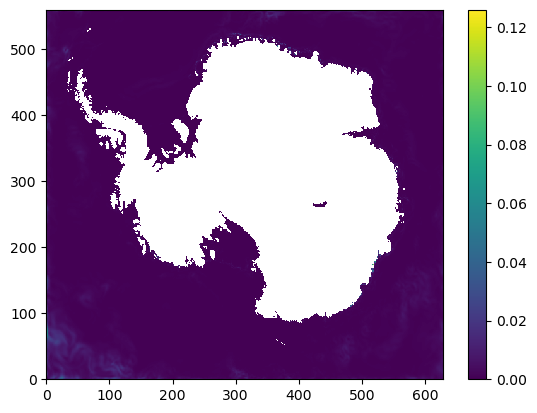

In [9]:
plt.pcolormesh(EKE_10km.mean('ocean_time'))
plt.colorbar()

In [21]:
# load lat/lon along 1500m/CF:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

expt = 'WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_10km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lat_along_10km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CF_v3')
lon_along_10km_CF = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CF_v3')
lat_along_10km_CF = ds.variables["two"]
ds.close()


expt = 'WAOM4'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_4km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lat_along_4km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CF_v3')
lon_along_4km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CF_v3')
lat_along_4km_CF = ds.variables["two"]
ds.close()

In [25]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Maps_validations/'

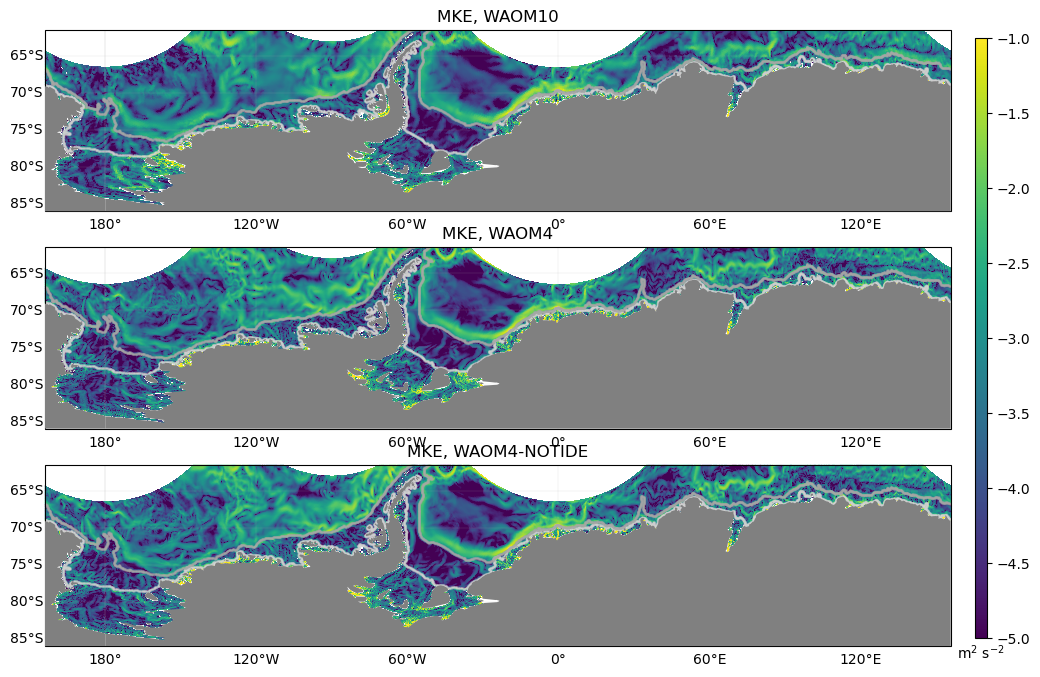

In [26]:
proj = ccrs.PlateCarree(central_longitude=-24)

fig = plt.figure(figsize=(12,8))
jst_10= 40
jen_10=-1
ist_10=0
ien_10=-1

ax1 = fig.add_subplot(3,1,1, projection=proj)
ct1a=plt.pcolormesh(lon_rho_10km[jst_10:jen_10,ist_10:ien_10].values,lat_rho_10km[jst_10:jen_10,ist_10:ien_10].values,
                   np.log10(MKE_10km.isel(eta_rho=slice(jst_10,jen_10),xi_rho=slice(ist_10,ien_10))), transform=ccrs.PlateCarree(), vmin=-5, vmax=-1)
                     
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('MKE, WAOM10')

gl=ax1.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .2
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

jst= 100
jen=-1
ist=0
ien=-1
ax2 = fig.add_subplot(3,1,2, projection=proj)
ct1a=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,
                   np.log10(MKE_4km.isel(eta_rho=slice(jst,jen),xi_rho=slice(ist,ien))), transform=ccrs.PlateCarree(), vmin=-5, vmax=-1)
                   
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('MKE, WAOM4')

gl=ax2.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax3 = fig.add_subplot(3,1,3, projection=proj)
ct1a=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,
                   np.log10(MKE_4kmNT.isel(eta_rho=slice(jst,jen),xi_rho=slice(ist,ien))), transform=ccrs.PlateCarree(), vmin=-5, vmax=-1)
                   
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('MKE, WAOM4-NOTIDE')

gl=ax3.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax3.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax3.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .2
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax2 = fig.add_axes([0.91, 0.12,  0.01, 0.75])
fig.colorbar(ct1a, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_xlabel('m$^{2}$ s$^{-2}$')#, labelpad=-35)

# cbar_ax3 = fig.add_axes([0.91, 0.665,  0.01, 0.06])
# fig.colorbar(cm1a, cax=cbar_ax3, orientation='vertical')
# cbar_ax3.set_xlabel('m/yr')#, labelpad=-35)

name_fig='waom10x4x4NT_MKE_maps_yr20.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


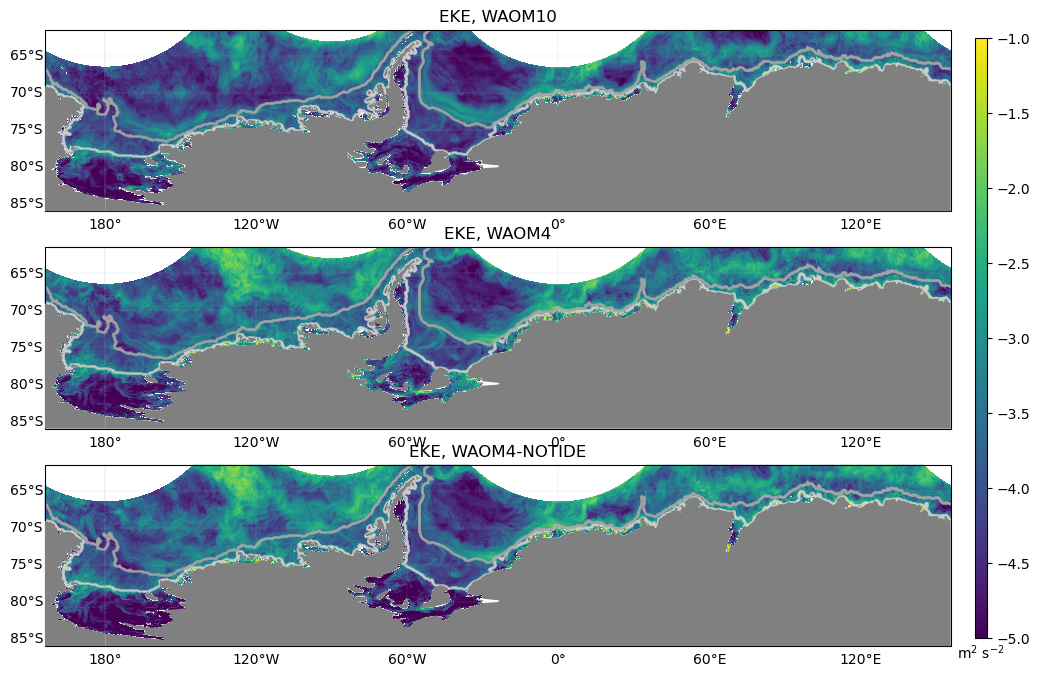

In [27]:
proj = ccrs.PlateCarree(central_longitude=-24)

fig = plt.figure(figsize=(12,8))
jst_10= 40
jen_10=-1
ist_10=0
ien_10=-1

ax1 = fig.add_subplot(3,1,1, projection=proj)
ct1a=plt.pcolormesh(lon_rho_10km[jst_10:jen_10,ist_10:ien_10].values,lat_rho_10km[jst_10:jen_10,ist_10:ien_10].values,
                   np.log10(EKE_10km.isel(eta_rho=slice(jst_10,jen_10),xi_rho=slice(ist_10,ien_10)).mean('ocean_time')), transform=ccrs.PlateCarree(), vmin=-5, vmax=-1)
                     
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('EKE, WAOM10')

gl=ax1.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .2
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

jst= 100
jen=-1
ist=0
ien=-1
ax2 = fig.add_subplot(3,1,2, projection=proj)
ct1a=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,
                   np.log10(EKE_4km.isel(eta_rho=slice(jst,jen),xi_rho=slice(ist,ien)).mean('ocean_time')), transform=ccrs.PlateCarree(), vmin=-5, vmax=-1)
                   
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('EKE, WAOM4')

gl=ax2.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax3 = fig.add_subplot(3,1,3, projection=proj)
ct1a=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,
                   np.log10(EKE_4kmNT.isel(eta_rho=slice(jst,jen),xi_rho=slice(ist,ien)).mean('ocean_time')), transform=ccrs.PlateCarree(), vmin=-5, vmax=-1)
                   
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('EKE, WAOM4-NOTIDE')

gl=ax3.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax3.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax3.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .2
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax2 = fig.add_axes([0.91, 0.12,  0.01, 0.75])
fig.colorbar(ct1a, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_xlabel('m$^{2}$ s$^{-2}$')#, labelpad=-35)

# cbar_ax3 = fig.add_axes([0.91, 0.665,  0.01, 0.06])
# fig.colorbar(cm1a, cax=cbar_ax3, orientation='vertical')
# cbar_ax3.set_xlabel('m/yr')#, labelpad=-35)

name_fig='waom10x4x4NT_EKE_maps_yr20.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


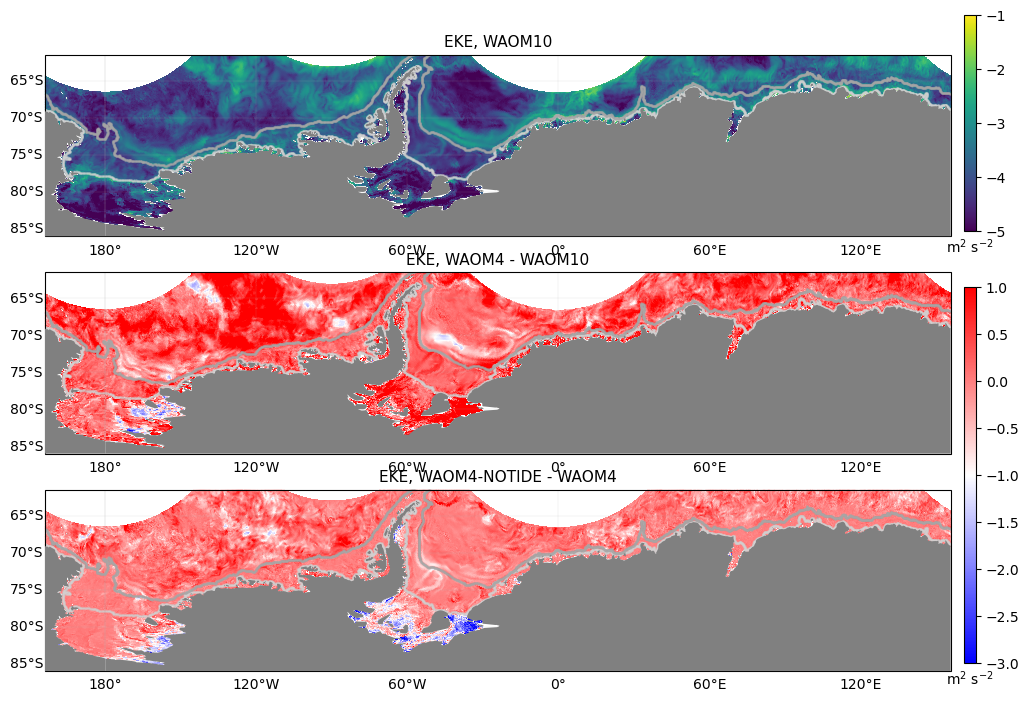

In [124]:
## ADD *4km_i - 10km), (4kmNT_i - 10km)

proj = ccrs.PlateCarree(central_longitude=-24)

fig = plt.figure(figsize=(12,8))
jst_10= 40
jen_10=-1
ist_10=0
ien_10=-1

ax1 = fig.add_subplot(3,1,1, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst_10:jen_10,ist_10:ien_10].values,lat_rho_10km[jst_10:jen_10,ist_10:ien_10].values,
                   np.log10(EKE_10km.isel(eta_rho=slice(jst_10,jen_10),xi_rho=slice(ist_10,ien_10)).mean('ocean_time')), transform=ccrs.PlateCarree(), vmin=-5, vmax=-1)
                     
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('EKE, WAOM10',fontsize=11)

gl=ax1.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax1.get_xlim() 
y_low, y_high = ax1.get_ylim()
ratio = .2
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.901, 0.66,  0.01, 0.27])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_xlabel('m$^{2}$ s$^{-2}$')#, labelpad=-35)

jst= 100
jen=-1
ist=0
ien=-1
ax2 = fig.add_subplot(3,1,2, projection=proj)
ct1a=plt.pcolormesh(lon_rho_10km[jst_10:jen_10,ist_10:ien_10].values,lat_rho_10km[jst_10:jen_10,ist_10:ien_10].values,
                   np.log10(EKE_4km_i[jst_10:jen_10,ist_10:ien_10])-
                    np.log10(EKE_10km.isel(eta_rho=slice(jst_10,jen_10),xi_rho=slice(ist_10,ien_10)).mean('ocean_time')),
                            transform=ccrs.PlateCarree(), cmap='bwr', vmin=-3, vmax=1)
                   
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('EKE, WAOM4 - WAOM10',fontsize=11)

gl=ax2.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

ax3 = fig.add_subplot(3,1,3, projection=proj)
ct1a=plt.pcolormesh(lon_rho_10km[jst_10:jen_10,ist_10:ien_10].values,lat_rho_10km[jst_10:jen_10,ist_10:ien_10].values,
                   np.log10(EKE_4kmNT_i[jst_10:jen_10,ist_10:ien_10])-
                    np.log10(EKE_4km_i[jst_10:jen_10,ist_10:ien_10]),
                            transform=ccrs.PlateCarree(), cmap='bwr', vmin=-3, vmax=1)

                   
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.2, color='lightgray',label='Calving front', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.2, color='darkgray',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('EKE, WAOM4-NOTIDE - WAOM4',fontsize=11)

gl=ax3.gridlines(draw_labels=True,linewidth=.1)
gl.top_labels=False   # suppress top labels
ax3.add_feature(cfeature.LAND, zorder=3, facecolor='gray') # , edgecolor='white', 
ax3.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())

x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .2
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax2 = fig.add_axes([0.901, 0.12,  0.01, 0.47])
fig.colorbar(ct1a, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_xlabel('m$^{2}$ s$^{-2}$')#, labelpad=-35)\

name_fig='waom10x4x4NT_EKE-anom_maps_yr20.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')
